In [13]:
# import modules
import sys
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
import os

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from functions_EDX import *

import torch
print("PyTorch version:", torch.__version__)
print("CUDA is available:", torch.cuda.is_available())
from skimage.filters import gaussian 
from segment_anything_hq import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from skimage.feature import peak_local_max

PyTorch version: 2.3.0
CUDA is available: False


### functions

In [3]:
# sub-routine to get file names
def get_file_paths(spectrum_folder):
    file_names = []
    tmp = os.listdir(spectrum_folder)
    for filename in tmp:
        if filename.endswith('.npz'):
            file_names.append(filename)
    
    file_names = sorted(file_names)
    files = [os.path.join(spectrum_folder,file_name) for file_name in file_names]
    return files

def show_mask(mask, ax, random_color=False,alpha=0.35):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, alpha])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)   

### structure indices

In [24]:
structure_names = ['Cytoplasm','Insulin','Nucleic acids','Exocrine granules','PP or Ghrelin','Glucagon',
              'Membranes','Lysosomes A','Lysosomes B','Lysosomes C','Nucleolus','Lysosomes D']

# print structure indices
for idx, structure in enumerate(structure_names):
    print("%02d - %s" % (idx,structure))

00 - Cytoplasm
01 - Insulin
02 - Nucleic acids
03 - Exocrine granules
04 - PP or Ghrelin
05 - Glucagon
06 - Membranes
07 - Lysosomes A
08 - Lysosomes B
09 - Lysosomes C
10 - Nucleolus
11 - Lysosomes D


### Load ColorEM data

In [25]:
# choose a tile and a structure to segment
tile_idx = 4
structure_idx = 5

supp_file_path = '/Users/AJ/Desktop/PACMAP_RESULTS/Identify2/pacpam_instance/pacmap_panc_euc_20percent_SavedTree20240209-105636.npz'
abundance_maps = np.load(supp_file_path)['abundance_maps']
abundance_maps = abundance_maps / np.max(abundance_maps) # Scale to have max coefficient = 1
colors = np.load(supp_file_path)['colors']
colors[0] = [0,0,0]


# get HAADF img
spectrum_folder = '/Volumes/Microscopy3/EDX_data/Identify/main_mosaic_6by5/NPZ/'
files = get_file_paths(spectrum_folder)
haadf = rebin_XY(np.load(files[tile_idx])['haadf'],1024)

### Load SAM segmentation checkpoint and apply to haadf img

In [26]:
sam_checkpoint = "/Users/AJ/Desktop/work/PostDoc_UMCG/work/analysis/EDX_Project/SAMHQ/pretrained_checkpoint/sam_hq_vit_h.pth"
model_type = "vit_h"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)
predictor.set_image(cv.cvtColor(normalize8(haadf), cv.COLOR_BGR2RGB))

<All keys matched successfully>


### Prompt SAM with points from preprocessed abundance map

In [27]:
# Get the abundance map of the selected tile/structure and preprocess it
abundance_map = abundance_maps[structure_idx,:,:,tile_idx]
blurred = gaussian(abundance_map,4)
blurred_thresholded = blurred* (blurred>0.4)

# Find the local maxima of 
coordinates = peak_local_max(blurred_thresholded , min_distance=10)


# get masks for each local maximum
all_masks = []
for i in range(coordinates.shape[0]):
    input_point = np.array([(coordinates[i][1],coordinates[i][0])])
    input_label = np.array([1])
    
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    all_masks.append(masks)

print("Number of masks is: %d" % len(all_masks))

Number of masks is: 148


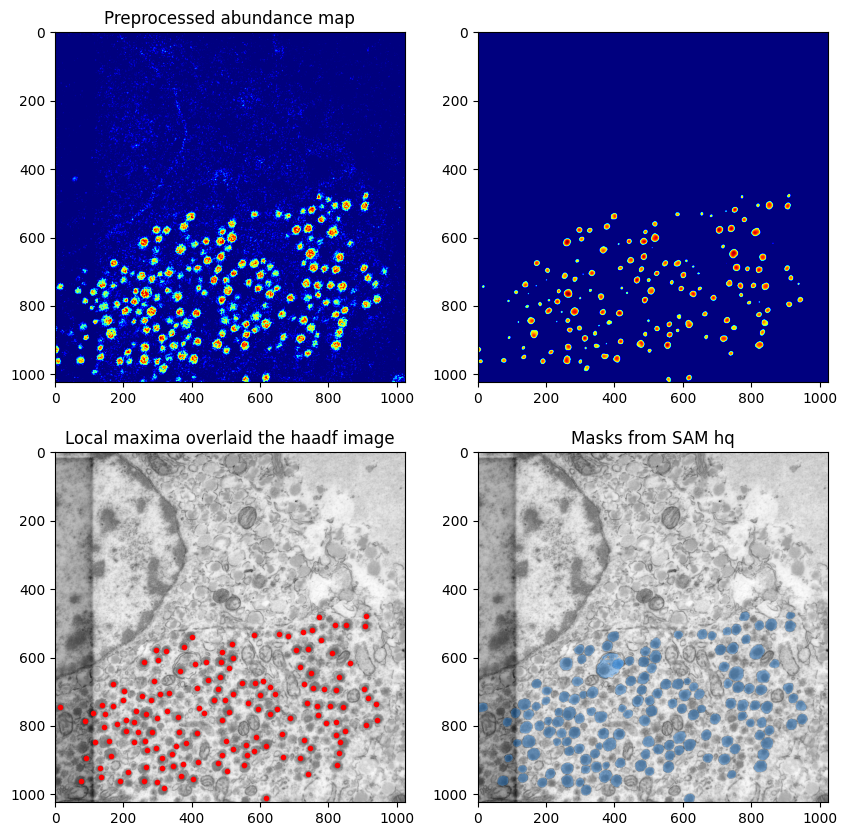

In [32]:
f, ax = plt.subplots(2,2,figsize = (10,10))
ax[0][0].imshow(abundance_map,cmap='jet')
ax[0][0].set_title('abundance map for %s, tile %02d' % (structure_names[structure_idx],tile_idx))
ax[0][1].imshow(blurred_thresholded,cmap='jet')
ax[0][1].set_title('Preprocessed abundance map')

ax[1][0].imshow(haadf,cmap='gray_r')
ax[1][0].autoscale(False)
ax[1][0].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[1][0].set_title('Local maxima overlaid the haadf image')

ax[1][1].imshow(haadf,cmap='gray_r')
ax[1][1].set_title('Masks from SAM hq')                                                       
for mask in all_masks:
    show_mask(mask, ax[1][1])

    
plt.show() 


### ColorEM img for reference

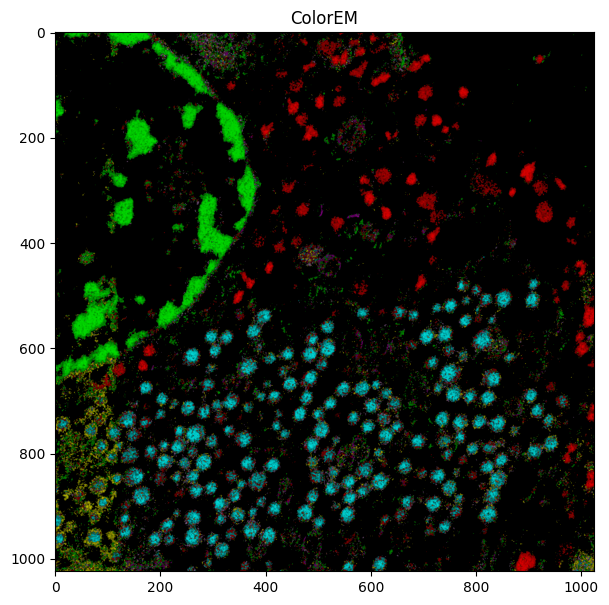

In [41]:
abundance_tile = abundance_maps[:,:,:,tile_idx]
rgb_image = np.zeros((3,abundance_tile.shape[1],abundance_tile.shape[2]))
for x in range(rgb_image.shape[1]):
    for y in range(rgb_image.shape[2]):
        idx = np.argmax(abundance_tile[:,x,y])
        rgb_image[0,x,y] = colors[idx][0]*abundance_tile[idx,x,y] if idx!=0 else colors[idx][0]*(1-abundance_tile[idx,x,y])
        rgb_image[1,x,y] = colors[idx][1]*abundance_tile[idx,x,y] if idx!=0 else colors[idx][1]*(1-abundance_tile[idx,x,y])
        rgb_image[2,x,y] = colors[idx][2]*abundance_tile[idx,x,y] if idx!=0 else colors[idx][2]*(1-abundance_tile[idx,x,y])

f,ax = plt.subplots(figsize=(7,7))
ax.imshow((rgb_image.transpose(1,2,0)*255).astype('uint8'))
ax.set_title('ColorEM')
plt.show()